# Proyecto 3 *GAN*

## Grupo 6

In [1]:
import random

# Alphabetic order
authors = [
    "Lluís Bernat Ladaria",
    "David Carretero García",
    "Ramón Rotaeche Fernández de la Riva"]

random.shuffle(authors)

print("Autores:")
print("========")
for a in authors: 
  print(f"- %s" % a, sep="\n")

Autores:
- Lluís Bernat Ladaria
- Ramón Rotaeche Fernández de la Riva
- David Carretero García


## Resumen

Presentamos nuestra propuesta de red *GAN* para la generación de dígitos manuscritos, 
basada en la librería *Pytorch*. 
Para elaborarla hemos considerado un subconjunto de elementos de esta librería.

### Elementos de la solución

Nuestra propuesta de red *GAN* se basa en los siguientes elementos: 

- Capas *Full Connected* (no usamos las convolucionales): pensamos que la dimensión de las imágenes es suficientemente pequeña como para poder tratarlas de forma eficiente con capas *FC*

- Capas *Dropout*: para evitar que la red memorize en lugar de aprender características usamos capas de olvido entre cada una de las *FC*

- Función de activación LeakyReLU(): esta función al ser no nula en todo su dominio excepto en x = 0, permite que la *backpropagation* sea *end-to-end*

- Función de activación Tanh(): la función de tangente hiperbólica funciona mejor que la sigmoide en el tratamiento de imágenes. 

Hemos combinado estos elementos en una arquitectura que describimos sucintamente acontinuación. 

### Arquitectura de la propuesta

La arquitectura de capas es la de la ilustración siguiente. 
Cabe destacar que para clasificar si las imágenes son verdaderas o falsas 
hemos considerado una clase para cada opción, es decir a la salida del discriminador 
obtenemos dos valores (hay dos neuronas), 
uno para indicar cuan de verdadera parece y 
el otro para indicar cuan de falsa parece. 
Pensamos que usar este planteamiento en lugar de uno con una sola neurona, 
va a promover un funcionamiento más eficiente en la 
red clasificadora del discriminador.

![Diagrama de las capas](assets/capas.jpg)

También debemos señalar que a la salida del discriminador no se aplica 
una función de activación al uso, sinó que a fin de conseguir una mayor estabilidad 
numérica la función de activación (que sería una sigmoide) 
y la de pérdida (que sería el cálculo de la entropía cruzada binaria) 
se combinan en una sola, 
llamada *BCEWithLogitsLoss* que optimiza el cálculo al aplicar 
las funciones logarítmicas del cálculo de la entropía 
a la sigmoide (que contiene una exponencial). 

### Resultados 

Después de múltiples pruebas combinando: 

- la dimensión de z a 25, 16 y 9 
- valores de Dropout de 0.01, 0.1, 0.2, 0.3, 0.4 y 0.5 
- número de epochs entre 40 y 100 

Hemos concluido que los resultados de mayor *credibilidad* que hemos 
podido conseguir con el generador son los que se 
consiguen con los parámetros e hiperparámetros 
que se presentan en los comentarios 
y el código de esta práctica. 

[Aquí puede consultar los parámetros de las capas](#Build-complete-network)

### Índice de comentarios

Además de este resumen, hay un total de **8 comentarios** señalizados 
de esta forma **>>> Comentario # <<<**:

[Comentario 1: estructura de capas del discriminador](#>>>-Comentario-1-<<<)

[Comentario 2: estructura de capas del generador](#>>>-Comentario-2-<<<)

[Comentario 3: hiperparámetros](#>>>-Comentario-3-<<<)

[Comentario 4: función de pérdida](#>>>-Comentario-4-<<<)


Los cuatro últimos sobre el código de [*Training*](#Training)

# Generative Adversarial Network

In this exercise, you'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, new handwritten digits will be generated!

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
> * The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

<img src='./gan_pipeline.png' width=70% />

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

If you're interested in generating only new images, you can throw out the discriminator after training. In this exercise, you will define and train these adversarial networks in PyTorch and generate new images!

In [2]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the data

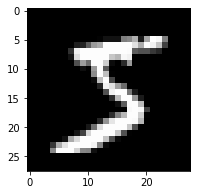

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, we'll need at least one hidden layer, and these hidden layers should have one key attribute:
> All hidden layers will have a [Leaky ReLu](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activation function applied to their outputs.

<img src='./gan_network.png' width=70% />

#### Leaky ReLu

We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values. It has a small slope for negative values, instead of altogether zero. For example, leaky ReLU may have y = 0.01x when x < 0.

<img src='./leaky_relu.png' width=40% />

#### Sigmoid Output

We'll also take the approach of using a more numerically stable loss function on the outputs. Recall that we want the discriminator to output a value 0-1 indicating whether an image is _real or fake_. 
> We will ultimately use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), which combines a `sigmoid` activation function **and** binary cross entropy loss in one function. 

So, our final output layer should not have any activation function applied to it.

## >>> Comentario 1 <<<


### Estructura de las capas del discrimidador

| Orden a aplicación | Comentario |
| :--- | :--- |
| FC1       | capa de entrada de la imatgen (gris) 28x28 |
| LeakyReLU | activación no lineal, recta con pendiente 0.01 para x<0 y pendiente 1 para x>=0 |
| Dropout   | para mitigar *overfitting* |
| FC2       | oculta, le asignamos la mitad del número de neuronas de salida + entrada |
| LeakyReLU | este tipo de función (no nula excepto en x=0) permite *backpropagation* plena (desde el discrimidador hasta la primera capa del generador) |
| Dropout   | |
| FC3       | capa de salida, nos dirá si la imagen es verdadera o falsa |

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Discriminator(nn.Module):

    
    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define all layers
        #TODO
        #DONE
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.do1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.do2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(hidden_dim, output_size)
        
       
    def forward(self, x):
        # flatten image
        #TODO
        #DONE 
        x = torch.flatten(x, 1)
        
        # pass x through all layers
        # apply leaky relu activation to all hidden layers
        #TODO
        #DONE
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.do1(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.do2(x)
        x = self.fc3(x)

        return x


## Generator

The generator network will be almost exactly the same as the discriminator network, except that we're applying a [tanh activation function](https://pytorch.org/docs/stable/nn.html#tanh) to our output layer.

#### tanh Output
The generator has been found to perform the best with $tanh$ for the generator output, which scales the output to be between -1 and 1, instead of 0 and 1. 

<img src='./tanh_fn.png' width=40% />

Recall that we also want these outputs to be comparable to the *real* input pixel values, which are read in as normalized values between 0 and 1. 
> So, we'll also have to **scale our real input images to have pixel values between -1 and 1** when we train the discriminator. 

This is done in the training loop, later on.

## >>> Comentario 2 <<<

### Estructura de las capas del generador

| Orden de aplicación | Comentario |
|:---|:---|
|FC1       | capa de entrada del ruido (entropia), suponemos imagen 4x4 |
|LeakyReLU | activación no lineal, recta con pendiente 0.01 para x<0 y pendiente 1 para x>=0 |
|Dropout   | mitigar *overfitting* |
|FC2       | oculta, le asignamos la mitad del número de neuronas de salida + entrada |
|LeakyReLU | este tipo de función (no nula excepto en x=0) permite *backpropagation* plena (desde el discrimidador hasta la primera capa del generador) |
|Dropout   |  |
|FC3       | capa de salida, tendrá la misma dimensión de las imágenes a comparar |
|Tanh      | la creación de imágenes funciona mejor usando valores del intervalo (-1,1) |


In [6]:
class Generator(nn.Module):

    
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define all layers
        #TODO
        #DONE
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.do1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.do2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        # pass x through all layers
        # final layer should have tanh applied
        #TODO
        #DONE
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.do1(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.do2(x)
        x = self.fc3(x)
        x = torch.tanh(x)        
        
        
        return x

## Model hyperparameters

## >>> Comentario 3 <<<

### Caso discriminador

Imagen (entrada) -> clasificación: verdadera o falsa (salida)

- Entra imagen monocromo de 28x28 píxeles: 1 * 28 * 28 
- Sale clasificación verdadera/falsa: en lugar de una sola neurona, usamos 2, una para cada clase (c1: imagen es verdadera, c2: imagen es falsa). Pensamos que usando dos neuronas para *mapear* dos clases, en lugar de una sola neurona, nos va a dar mayor robustez.
- Capa oculta: a falta de hacer pruebas, de momento la mitad de las neuronas de entrada + salida

### Caso generador

Ruido (entrada) -> imagen (salida)

- Entra entropía en forma de ruido, supondremos *imagen* monocroma de 4x4 píxeles: 4 * 4 * 1
- Sale imagen monocromo del mismo tamaño que las verdaderas: 28 * 28 * 1
- Capa oculta: a falta de hacer pruebas, de momento la mitad de las neuronas de entrada + salida

In [7]:
# Discriminator hyperparams
#TODO
#DONE
# Size of input image to discriminator (28*28)
input_size = 28 * 28 
# Size of discriminator output (real or fake)
d_output_size = 2
# Size of *last* hidden layer in the discriminator
d_hidden_size = (input_size + d_output_size) // 2

# Generator hyperparams
#TODO
#DONE
# Size of latent vector to give to generator
z_size = 4 * 4
# Size of discriminator output (generated image)
g_output_size = 28 * 28
# Size of *first* hidden layer in the generator
g_hidden_size = (z_size + g_output_size) // 2

## Build complete network

Now we're instantiating the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [8]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=393, bias=True)
  (do1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=393, out_features=393, bias=True)
  (do2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=393, out_features=2, bias=True)
)

Generator(
  (fc1): Linear(in_features=16, out_features=400, bias=True)
  (do1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (do2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=400, out_features=784, bias=True)
)


---
## Discriminator and Generator Losses

Now we need to calculate the losses. 

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

<img src='gan_pipeline.png' width=70% />

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the real images with a label = 1, indicating that these are real. To help the discriminator generalize better, the labels are **reduced a bit from 1.0 to 0.9**. For this, we'll use the parameter `smooth`; if True, then we should smooth our labels. In PyTorch, this looks like `labels = torch.ones(size) * 0.9`

The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

## >>> Comentario 4 <<<

En la capa de salida del discriminador tenemos dos neuronas que representan dos canales. 
El primero, para señalar las imágenes reales y el segundo para las falsas. 

### real_loss

Por tanto el tensor de etiquetas para el caso de querer calcular 
la función de pérdida de un lote tendrá unos (1) en 
la primera columna (canal para marcar las imágenes reales) y 
ceros (0) en la segunda columna (canal imágenes falsas) y 
tantas filas como imágenes en el lote.

Ejemplo de confección de etiquetas para un lote de 5 imágenes reales:

```python
labels = torch.zeros([5,2]) # lotes de 5 imágenes, dos canales
labels[:,0] = 1
print(labels)
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
```

### fake_loss

Aquí deberemos etiquetar como correcta la imagen falsa. 
Por tanto el tensor de etiquetas tendrá su segunda columna a unos (1) y 
la primera a ceros (0).

In [9]:
# Calculate losses

def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    #TODO
    #DONE
    
    labels = torch.zeros(D_out.shape)
    
    if smooth:
        labels[:,0] = 0.9 # Primera columna a 0.9
    else:
        labels[:,0] = 1.0 # Primera columna a uno (1)
        
    criterion = torch.nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out, labels)
    
    return loss

def fake_loss(D_out):
    # compare logits to fake labels
    #TODO
    #DONE
    
    labels = torch.zeros(D_out.shape)
    
    labels[:,1] = 1.0 # Sólo segunda columna a uno (1)
        
    criterion = torch.nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out, labels)
    
    return loss

## Optimizers

We want to update the generator and discriminator variables separately. So, we'll define two separate Adam optimizers.

In [10]:
import torch.optim as optim

# learning rate for optimizers
lr = 0.002


# Create optimizers for the discriminator and generator
#TODO
#DONE

d_optimizer = optim.Adam(D.parameters(), lr)

g_optimizer = optim.Adam(G.parameters(), lr)

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [11]:
import pickle as pkl

# training hyperparams
num_epochs = 100  #TODO (it could be changed) #DONE

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images * (-2) + 1  # rescale input images from [0,1) to [-1, 1)
        
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        #TODO
        #DONE
        
        # >>> Comentario 5 <<<
        #
        # el re-escalado a [-1, 1) de las imágenes (línea anterior a este comentario) 
        # ha sido invertido para obtenerlas en trazo negro sobre fondo blanco 
        # porque nos gusta más así :-) 
        #
        # empezamos otro lote, así que hay que 
        # poner a cero los gradientes acumulados en el ciclo anterior 
        #
        D.zero_grad()

        # 1. Train with real images
        # Compute the discriminator losses on real images
        # use smoothed labels
        
        d_real_decision = D(real_images)
        
        d_real_loss = real_loss(d_real_decision, smooth = True)         
        
        #TODO
        #DONE
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        #fake_images = G(z)
        #
        # >>> Comentario 6 <<<
        #
        # detach() para evitar el cálculo innecesario de los gradientes 
        # en el generador 
        #
        fake_images = G(z).detach()
        
        # Compute the discriminator losses on fake images        
        #TODO
        #DONE
        
        # >>> Comentario 7 <<<
        #
        # pasamos el lote de imágenes falsas por el discriminador
        #
        d_fake_decision = D(fake_images)
        
        d_fake_loss = fake_loss(d_fake_decision)
        
        # add up real and fake losses and perform backprop
        #TODO
        #DONE
        
        d_loss = d_real_loss + d_fake_loss
        
        d_loss.backward()
        
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        #TODO
        #DONE
        
        G.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        #TODO
        #DONE
        
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        #TODO
        #DONE
        
        # >>> Comentario 8 <<<
        #
        # pasamos el lote de imágenes falsas por el discriminador
        #
        g_fake_decision = D(fake_images)
        
        # perform backprop
        #TODO
        #DONE
        
        g_loss = real_loss(g_fake_decision)
        
        g_loss.backward()
        
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.3629 | g_loss: 0.6955
Epoch [    1/  100] | d_loss: 0.6467 | g_loss: 5.8848
Epoch [    1/  100] | d_loss: 0.3686 | g_loss: 4.9208
Epoch [    2/  100] | d_loss: 0.9999 | g_loss: 1.8344
Epoch [    2/  100] | d_loss: 0.4877 | g_loss: 4.2266
Epoch [    2/  100] | d_loss: 0.8777 | g_loss: 2.3573
Epoch [    3/  100] | d_loss: 0.9087 | g_loss: 2.2708
Epoch [    3/  100] | d_loss: 0.8059 | g_loss: 1.8934
Epoch [    3/  100] | d_loss: 0.8141 | g_loss: 1.8604
Epoch [    4/  100] | d_loss: 1.1674 | g_loss: 1.6101
Epoch [    4/  100] | d_loss: 0.6469 | g_loss: 1.7969
Epoch [    4/  100] | d_loss: 0.6966 | g_loss: 2.8498
Epoch [    5/  100] | d_loss: 0.9479 | g_loss: 1.8198
Epoch [    5/  100] | d_loss: 0.7920 | g_loss: 2.1537
Epoch [    5/  100] | d_loss: 0.9547 | g_loss: 1.5441
Epoch [    6/  100] | d_loss: 0.8249 | g_loss: 1.7607
Epoch [    6/  100] | d_loss: 1.0490 | g_loss: 1.7918
Epoch [    6/  100] | d_loss: 0.9895 | g_loss: 1.2462
Epoch [    7/  100] | d_loss

Epoch [   51/  100] | d_loss: 1.1045 | g_loss: 1.4116
Epoch [   52/  100] | d_loss: 1.0527 | g_loss: 1.5588
Epoch [   52/  100] | d_loss: 1.1332 | g_loss: 1.1816
Epoch [   52/  100] | d_loss: 1.1618 | g_loss: 1.1627
Epoch [   53/  100] | d_loss: 1.0604 | g_loss: 1.2802
Epoch [   53/  100] | d_loss: 1.0399 | g_loss: 1.2407
Epoch [   53/  100] | d_loss: 1.0710 | g_loss: 1.2809
Epoch [   54/  100] | d_loss: 1.1023 | g_loss: 1.7144
Epoch [   54/  100] | d_loss: 1.2234 | g_loss: 1.5108
Epoch [   54/  100] | d_loss: 1.0958 | g_loss: 1.1212
Epoch [   55/  100] | d_loss: 0.9168 | g_loss: 1.5582
Epoch [   55/  100] | d_loss: 0.9347 | g_loss: 1.2542
Epoch [   55/  100] | d_loss: 1.0115 | g_loss: 1.3014
Epoch [   56/  100] | d_loss: 1.0655 | g_loss: 1.7834
Epoch [   56/  100] | d_loss: 1.1492 | g_loss: 1.5283
Epoch [   56/  100] | d_loss: 1.1039 | g_loss: 1.1989
Epoch [   57/  100] | d_loss: 1.1619 | g_loss: 1.6426
Epoch [   57/  100] | d_loss: 0.9768 | g_loss: 1.4038
Epoch [   57/  100] | d_loss

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

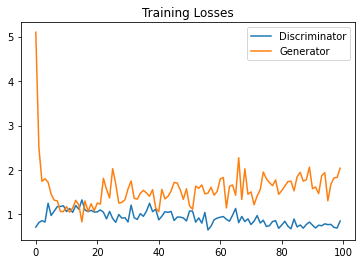

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at the images we saved during training.

In [13]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [14]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 1, 7, 3, 2. Since this is just a sample, it isn't representative of the full range of images this generator can make.

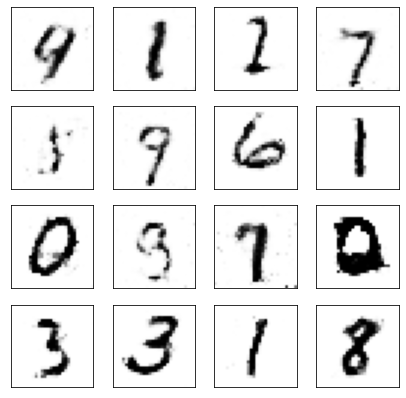

In [15]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Below the generated images are shown, as the network was training, every 10 epochs.

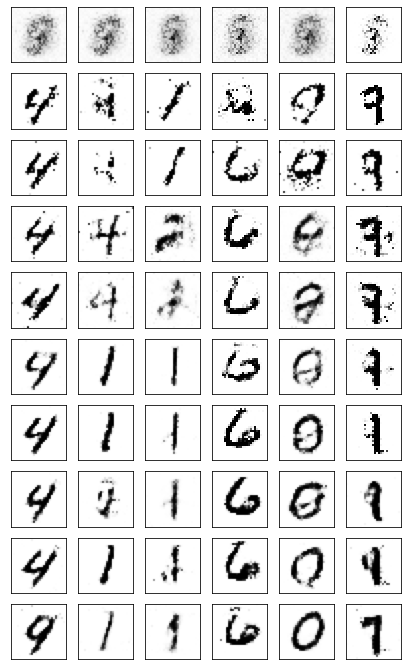

In [16]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise like 1s and 9s.

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. **We just need to pass in a new latent vector $z$ and we'll get new samples**!

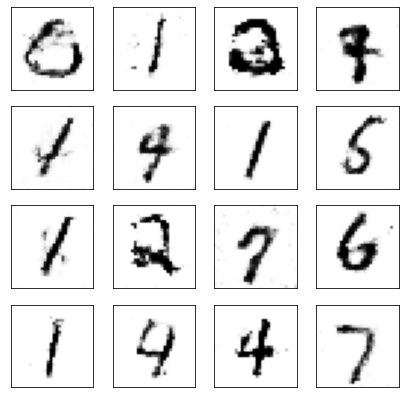

In [17]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])